# What will the U.S. geriatric population amount look like over time?

The expected lifespan for the U.S. population has been increasing over the years, due to various factors, such as improvements in medical technology and cleaner and safer working conditions. More members of the populace are expected to reach old age, and more are expected to be around in the future. This leads to thinking of what impact this growing aging population has on the rest of the populace, which in turn brings up a more fundamental question - how will the amount of aging individuals in the population change over time?

This model seeks to answer that question by building a population growth model centered around age demographics. The model focuses on slices of the population, and focuses on how the amount of individuals in each slice changes over time. In addition to this, the probability of death is determined for each slice of the population. The model will simulate the growth of the population using this model for 60 years, before determining where the state of the aging population is.

The model uses 2010 Age Demographic Census Data as the starting point for simulation.

# Data Parsing

In order to model age demographics, we follow a kind of 'bucket' based modeling, where the population is divided into buckets based on age. As the years go by, members flow from one bucket to another. Each bucket has an associated birth and death rate as well (the birth rate only applies to newborn, while the death rate applies to all buckets, at varying values) - the handling of birth and death rates is discussed in the next section. The collection of buckets comprises the main state of the simulation, the age demographic based population count.

Using Census data (age demographic data), we construct our initial population bucket states. The states are organized into a Series object, with each index corresponding to a certain age. The index is equivalent to the age value of each bucket (the last index of the buckets is equivalent to the cap-off age (100), where the oldest of the populace are bundled together).

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [3]:
# Load the initial data set, located in the same directory
init_age_data = sio.loadmat('AgeDemographicData.mat')['AgeDemographicData']

# Parse the data set - use the second column for age demographic data, the first column for age value indexing
init_data = pd.Series(init_age_data[:,1], index=init_age_data[:,0])

In [4]:
def initialize_state():
    state = pd.Series()
    buckets = pd.Series(index = np.linspace(0,100,101,dtype=int))
    for i in init_data.index:
        if i == init_data.index[0]:
            state['total'] = init_data[i]
            k = i
        else:
            pop_value = init_data[i]/(i-k)
            for j in range(k, i):
                if j <= 100:
                    buckets[j]=pop_value
                else:
                    buckets[100] = pop_value + buckets[100]
            k = i
    state['buckets'] = buckets
    return state

In [5]:
state=initialize_state()

# Model Construction

The model's main focus is to create an update function that can handle the change in longevity. This includes developing the concept of birth and death rates. In this 'bucket modeling' system, this means the following:
  * The birth rate is assumed as dependent on a simplistic model for birth rate - the simulation runs from the start of the data (2010) for 60 years, so that those in the elderly range (65+) are unaffected by the birth rate assumption. 
  * The death rate is assumed as constant for all ages. It will later be determined by a function of the age group involved, and changes (increase) as the ages get older.

With this in mind, the update function has the following structure:
  * Enter bucket
    * Check if the bucket is the last bucket:
      * Only apply death rate to this bucket
      * Add population number from previous bucket to this bucket
    * Check if the bucket is the first bucket:
      * Apply the death rate to the current amount in the first bucket
      * Store resulting population number into interim variable
      * Apply the birth rate
      * Set the amount born as new value for first bucket
    * If neither:
      * Apply death rate to the current bucket amounts
      * Store resulting population number into interim variable
      * Receive population number of previous bucket from another interim variable, set equal to new population bucket amount
    * Exit bucket
  * Loop through next buckets till completion of bucket updates

In [6]:
"""
`system` is an object that holds the parameters of the system:
    t_0: The start time of the simulation. This is when the data used to create the initial state was taken.
    t_end: Simulation end time.
    death: Array of death rates for each bucket of population. Current value was arbitrarily chosen
"""

system = pd.Series({'t_0': 2010, 't_end': 2070,
                    'death':pd.Series(np.zeros(101)+0.01, index=np.linspace(0,100,101, dtype=int)),
                    'birth': 0.012})


In [17]:
def birth_func(buckets):
    relevant_pop = [buckets[15:20],buckets[20:25],buckets[25:30],buckets[30:35],buckets[35:40],buckets[40:45]]
    females=[]
    for i in relevant_pop:
        tot=sum(i)
        females.append(tot/2)
        
    birth_rates=[.0342,.090,.1083,.0965,.0459,.0102]
    
    births=0
    for i in np.arange(0,4,1):
        births=births+females[i]*birth_rates[i]
    return births

In [25]:
def update_buckets(t, state,params):
    """
    Takes current state variable containing bucket data, and updates all buckets to reflect passing of a year.
    
    Parameters:
        t: Time (in years) of simulation.
        state: Series object containing data about bucket states and total population
            buckets: Contains the actual bucket data, split into buckets per age.
            total: Records total population amount
        params: Series object containing relevant data for updating buckets.
            birth: Birth rate of population
            death: Array of death rates per bucket
            
    Returns:
        state: Updated state variable
    """
    
    # Update the number of individuals per each bucket that died over the year
    state['buckets'] = state['buckets'] - state['buckets'] * params['death']
    
    # Determine number of newborns born in a year based on current buckets
    newborns = birth_func(state['buckets'])
    
    # Create interim bucket state, to hold what population data needs to be updated and shifted
    # Shift the first 99 years of data, and add in the amount of newborns into the first slot to complete
    interim_buckets = pd.concat([pd.Series([newborns]), state['buckets'][0:-1]], ignore_index = True)
    
    # Add the previous number of living 100+ year olds to the new number of living 100 year olds
    interim_buckets[interim_buckets.index[-1]] = interim_buckets[interim_buckets.index[-1]] + state['buckets'][-1:]
    
    # Update the state variable
    state['buckets'] = interim_buckets
    
    # Calculate the new total population amount
    state['total'] = interim_buckets.sum()
    
    # Return the updated state
    return state

update_buckets(2010,state,system)

total                                                 275496
buckets    0      3063.332284
1      3838.136028
2      3...
dtype: object

# Simulation

Using the update function defined in the **Model Construction** section, the simulation is defined as moving through a period of time, updating the buckets with each timestep. The results of each update is stored in a Dataframe object, so that the evolution of each individual bucket can be seen in the end; a column is also be added for the total population amount.

In [8]:
def run_simulation(state, system, update_func):
    t_interval = system['t_end'] - system['t_0'] + 1
    t_range = np.linspace(system['t_0'], system['t_end'], t_interval, dtype = int)
    
    results = pd.DataFrame(columns = np.concatenate((np.array(state['buckets'].index),
                                                      np.array('total')), axis = None),
                           index = t_range)
    
    for t in np.linspace(system['t_0'], system['t_end'], t_interval, dtype = int):
        state = update_func(t, state, system)
        results.iloc[t-system['t_0']] = pd.concat([state['buckets'], 
                                                   pd.Series(state['total'])], 
                                                  ignore_index = True).values
    return results

# Results

There are four graphs to indicate the results: the evolution of total population over time, the evolution of the elderly population over time, and the initial and final states of age demographics (in pie charts). These will provide a snapshot of the model's projection for the effect of increasing longevity on the population.

In [9]:
def plot_figures(res):
    newborn_pop = res.loc[:,'0':'1'].sum(axis = 1)
    minor_pop = res.loc[:,'2':'18'].sum(axis = 1)
    middle_pop = res.loc[:,'19':'64'].sum(axis = 1)
    senior_pop = res.loc[:,'65':'84'].sum(axis = 1)
    geriatric_pop = res.loc[:,'85':'100'].sum(axis = 1)
    total_pop = res.loc[:,'total']
    
    plt.figure()
    total_pop.plot()
    plt.title('Total population over time')
    plt.xlabel('Year')
    plt.ylabel('Population (thousands)')

    plt.figure()
    newborn_pop.plot()
    minor_pop.plot()
    middle_pop.plot()
    senior_pop.plot()
    geriatric_pop.plot()
    plt.legend(['Newborn (0-1)', 'Minor (2-18)', 'Middle (19-64)', 'Senior (65-84)', 'Geriatric (85-100)'])
    plt.xlabel('Year')
    plt.ylabel('Population (thousands)')


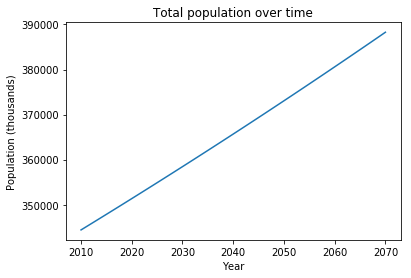

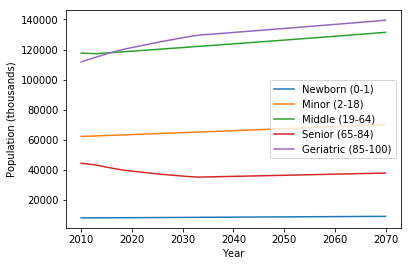

In [16]:
def results_main():
    res = run_simulation(state, system, update_buckets)
    plot_figures(res)
    return res
    
results=results_main()

# Validation

Because this model deals in the space of future population projection, there are two ways to validate the model: start simulation in the past, such that it can be compared with actual data, or compare the data against projections provided by institutes such as the US Census or the UN DESA. These will provide a sense of the model's reasonability. 

In [13]:
#load census population projection data
init_proj_data = sio.loadmat('census_pop_projections.mat')['num']
proj_data = pd.Series(init_proj_data[:,1], index=init_proj_data[:,0])


In [20]:
def plot_validation(res):
    total_pop = res.loc[:,'total']
    plt.figure()
    total_pop.plot()
    proj_data.plot()
    plt.title('Total population over time')
    plt.xlabel('Year')
    plt.ylabel('Population (thousands)')
    plt.legend(['Model Results','Census Projection'])

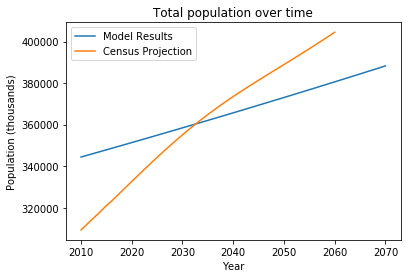

In [21]:
plot_validation(results)

# Interpretation

The model's results are indicative of the effects of increasing longevity on the population. Compared to Japan, which is already experiencing the effects of an 'aging population', the model shows that ----. In addition to simply predicting the number of elderly that will be in the world, the model also serves a basis for improvements/alterations in public policy geared towards and effecting the elderly population, such as policies for Social Security funds management, and hospital grant allocation.